# Bike Sharing Demand Prediction

**Dataset (recommended):** UCI Bike Sharing Dataset (hour.csv / day.csv) — the notebook downloads the UCI zip and reads `hour.csv` for hourly demand forecasting. See links in the top of the notebook.

**Suggested sources (you can also use Kaggle mirrors):**
- Kaggle competition / dataset: Bike Sharing Demand. 
- UCI Machine Learning Repository: Bike Sharing Dataset (contains `hour.csv` and `day.csv`).

This notebook performs:
- Data load (from UCI zip)
- EDA and visualization
- Feature engineering (datetime -> cyclical features)
- Preprocessing (train/test split, scaling)
- Train regression models: Linear Regression, Random Forest, Gradient Boosting
- Evaluate with RMSE, MAE, R² and save model files



In [1]:
# Imports
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib


In [2]:
# Download and load the dataset from UCI repository (zip contains hour.csv and day.csv)
# If running locally, you can replace the URL with a downloaded local file.
import urllib.request

zip_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip"
zip_path = "Bike-Sharing-Dataset.zip"

if not os.path.exists(zip_path):
    print('Downloading dataset zip from UCI...')
    urllib.request.urlretrieve(zip_url, zip_path)
else:
    print('Zip already exists.')

with zipfile.ZipFile(zip_path, 'r') as z:
    # list files
    print('Files in zip:', z.namelist())
    # read hour.csv into pandas directly
    with z.open('hour.csv') as f:
        df = pd.read_csv(f)
        
print('Loaded dataframe shape:', df.shape)
df.head()


Zip already exists.
Files in zip: ['Readme.txt', 'day.csv', 'hour.csv']
Loaded dataframe shape: (17379, 17)


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


Columns: ['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  reg

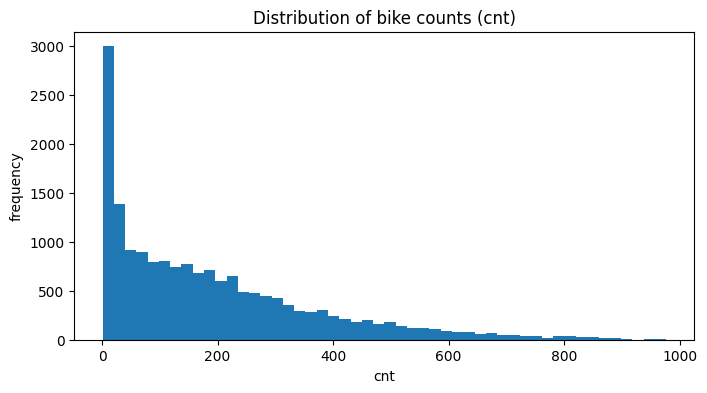

In [3]:
# Basic EDA
print('Columns:', df.columns.tolist())
print('\nInfo:')
print(df.info())
print('\nDescribe:')
print(df.describe())
print('\nTarget distribution (cnt):')
print(df['cnt'].describe())
plt.figure(figsize=(8,4))
plt.hist(df['cnt'], bins=50)
plt.title('Distribution of bike counts (cnt)')
plt.xlabel('cnt')
plt.ylabel('frequency')
plt.show()


In [4]:
# Feature engineering: parse datetime and create cyclical time features
df['dteday'] = pd.to_datetime(df['dteday'])
# hour is already present as 'hr' in hourly file; but create from datetime to be safe
if 'hr' not in df.columns:
    df['hr'] = df['dteday'].dt.hour
# create cyclical features for hour, day of week, month
df['hour_sin'] = np.sin(2 * np.pi * df['hr'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hr'] / 24)
df['dayofweek'] = df['dteday'].dt.dayofweek
df['dow_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
df['dow_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
df['month'] = df['dteday'].dt.month
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df[['dteday','hr','cnt','hour_sin','hour_cos','dayofweek','dow_sin','dow_cos','month']].head()


,dteday,hr,cnt,hour_sin,hour_cos,dayofweek,dow_sin,dow_cos,month
0,2011-01-01,0,16,0.000000,1.000000,5,-0.974928,-0.222521,1
1,2011-01-01,1,40,0.258819,0.965926,5,-0.974928,-0.222521,1
2,2011-01-01,2,32,0.500000,0.866025,5,-0.974928,-0.222521,1
3,2011-01-01,3,13,0.707107,0.707107,5,-0.974928,-0.222521,1
4,2011-01-01,4,1,0.866025,0.500000,5,-0.974928,-0.222521,1


In [5]:
# Select features for modeling
# drop columns not needed and the target 'cnt'
drop_cols = ['instant','dteday','casual','registered'] if set(['casual','registered']).issubset(df.columns) else ['instant','dteday']
X = df.drop(columns=drop_cols + ['cnt'], errors='ignore')
y = df['cnt']

# simple train-test split by time (last 20% as test)
split_idx = int(len(df)*0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)


Train shape: (13903, 20) Test shape: (3476, 20)


In [6]:
# Scale numeric features where appropriate
numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])
joblib.dump(scaler, 'bike_scaler.joblib')


['bike_scaler.joblib']

In [7]:
# Train baseline Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
def eval_reg(y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred)#, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {'rmse':rmse,'mae':mae,'r2':r2}

lr_metrics = eval_reg(y_test, y_pred_lr)
print('Linear Regression metrics:', lr_metrics)
joblib.dump(lr, 'lr_model.joblib')


Linear Regression metrics: {'rmse': 27433.961756231765, 'mae': 121.74087714725654, 'r2': 0.43567258143642273}


['lr_model.joblib']

In [8]:
# Random Forest Regressor (no heavy tuning here)
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)  # tree-based models work fine without scaled features
y_pred_rf = rf.predict(X_test)
rf_metrics = eval_reg(y_test, y_pred_rf)
print('Random Forest metrics:', rf_metrics)
joblib.dump(rf, 'rf_model.joblib')


Random Forest metrics: {'rmse': 5105.233869483346, 'mae': 46.92695435366321, 'r2': 0.8949833248172973}


['rf_model.joblib']

In [9]:
# Gradient Boosting Regressor
gb = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
gb_metrics = eval_reg(y_test, y_pred_gb)
print('Gradient Boosting metrics:', gb_metrics)
joblib.dump(gb, 'gb_model.joblib')


Gradient Boosting metrics: {'rmse': 7727.418810234296, 'mae': 59.48134580803882, 'r2': 0.8410439458913158}


['gb_model.joblib']

In [10]:
# Compare results
results = pd.DataFrame([lr_metrics, rf_metrics, gb_metrics], index=['LinearRegression','RandomForest','GradientBoosting'])
results


,rmse,mae,r2
LinearRegression,27433.961756,121.740877,0.435673
RandomForest,5105.233869,46.926954,0.894983
GradientBoosting,7727.418810,59.481346,0.841044


Best by RMSE: RandomForest


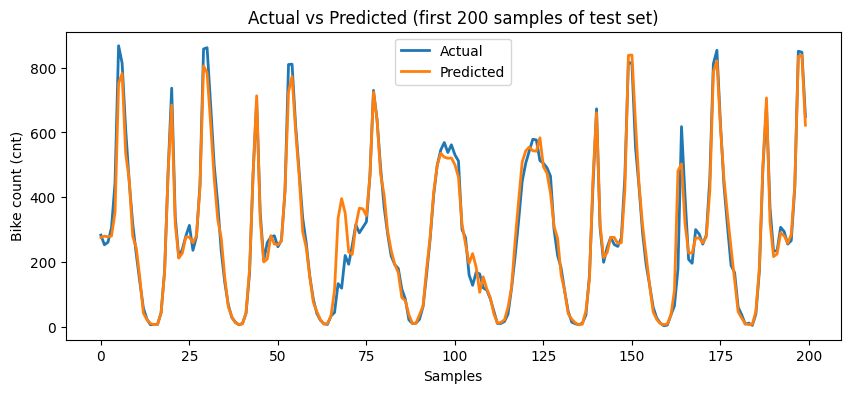

In [11]:
# Plot actual vs predicted for best model (by RMSE)
best = results['rmse'].idxmin()
print('Best by RMSE:', best)
if best == 'LinearRegression':
    y_pred = y_pred_lr
elif best == 'RandomForest':
    y_pred = y_pred_rf
else:
    y_pred = y_pred_gb

plt.figure(figsize=(10,4))
plt.plot(y_test.values[:200], label='Actual', linewidth=2)
plt.plot(y_pred[:200], label='Predicted', linewidth=2)
plt.title('Actual vs Predicted (first 200 samples of test set)')
plt.xlabel('Samples')
plt.ylabel('Bike count (cnt)')
plt.legend()
plt.show()

In [12]:
# Save evaluation results
results.to_csv('bike_model_results.csv', index=True)
print('Saved models: lr_model.joblib, rf_model.joblib, gb_model.joblib, scaler: bike_scaler.joblib')

Saved models: lr_model.joblib, rf_model.joblib, gb_model.joblib, scaler: bike_scaler.joblib
